In [1]:
from modelData import ModelData
from boltz.boltzmannEq import dYdx, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp,odeint
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [2]:
parfile = './input_parameters_FO.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [3]:
pars = parser['SolverParameters']
atol = pars['atol']
rtol = pars['rtol']
T0 = pars['T0']
Tf = pars['Tf']
method = pars['method']
nsteps = pars['nsteps']
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
paramCard = os.path.join(outputFolder,'Cards','param_card.dat')
sigmaVFile = os.path.join(outputFolder,'output','taacs.csv')
dm = parser['Model']['darkmatter']
bsmList = []
if 'bsmParticles' in parser['Model']:
    bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, paramCard=paramCard, sigmaVfile=sigmaVFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf    


In [4]:
# Set initila conditions
y0 = np.array([comp.Yeq(T0) for comp in compDict.values()])    
if 'initialConditions' in pars:
    # Set initila conditions
    initialCond = pars['initialConditions']    
    for label,comp_y0 in initialCond.items():
        pdg = model.convert2PDG(label)
        comp = compDict[pdg]            
        if isinstance(comp_y0,float):
            y0[comp.ID] = y0
        elif comp_y0.lower() in ['eq', 'equilibrium']:
            continue # Already set


In [5]:
# Initial conditions
x0, xf = 0.1,100.0
setLogLevel('info')

### Check terms in initial conditions

In [6]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.2776566338315371 0.27765663383153705
xd 0.007802996735312518 0.007802996735312518


In [7]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'xdxdx_ddx': 3.0267967740779398e-33, 'xdxdx_uux': 3.0267967740779398e-33, 'xdxdx_ssx': 3.0267967740779398e-33, 'xdxdx_ccx': 3.0267967740779398e-33, 'xdxdx_bbx': 3.0267967740779398e-33, 'xdxdx_ttx': 3.0267967740779398e-33}]
[[0. 0.]
 [0. 0.]]


In [8]:
for process in model.collisionProcesses:
    sigma = process.sigmaV(x0)
    print(f'Process {process.name} : sigmav = {sigma}')

Process xdxdx_ddx : sigmav = 1.1166909090909085e-13
Process xdxdx_uux : sigmav = 1.1166909090909085e-13
Process xdxdx_ssx : sigmav = 1.1166909090909085e-13
Process xdxdx_ccx : sigmav = 1.1166909090909085e-13
Process xdxdx_bbx : sigmav = 1.1166909090909085e-13
Process xdxdx_ttx : sigmav = 1.1166909090909085e-13


In [9]:
print(dYdx(x0,y0,model))

[0.00000000e+00 3.86706736e-09]


### Solve equations

In [10]:
# Run solve once
sol = solve_ivp(dYdx, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='BDF')
# sol = solve_ivp(boltz, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='LSODA', max_step = 0.01)


In [11]:
# xvals = np.linspace(x0,xf,100)
# #solving the Boltzmann equation
setLogLevel('info')
# Yf_sol = [y0]
# xi = x0
# yi = y0[:]
# for x in xvals[1:]:
#     yi = solve_ivp(boltz, [xi,x], yi, args=(model,), atol = atol, rtol = rtol, method='BDF').y[:,-1]
#     Yf_sol.append(yi)
#     xi = x
# Yf_sol = np.array(Yf_sol).transpose()

# # from scipy import integrate
# # ode15s = integrate.ode(boltz)
# # ode15s.set_integrator('vode', method='bdf', order=15)
# # ode15s.set_initial_value(y0, x0)
# # ode15s.set_f_params(model)

# # Yf_sol = [y0]

# # for x in xvals[1:]:
# #     print(x)
# #     Yf_sol.append(ode15s.integrate(x))
# # Yf_sol = np.array(Yf_sol).transpose()

In [12]:
# Yf_sol.shape

In [13]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-01  1.202e-01 ...  9.080e+01  1.000e+02]
        y: [[ 2.777e-01  2.777e-01 ...  2.777e-01  2.777e-01]
            [ 7.803e-03  7.803e-03 ...  1.749e-10  1.704e-10]]
      sol: None
 t_events: None
 y_events: None
     nfev: 663
     njev: 66
      nlu: 148

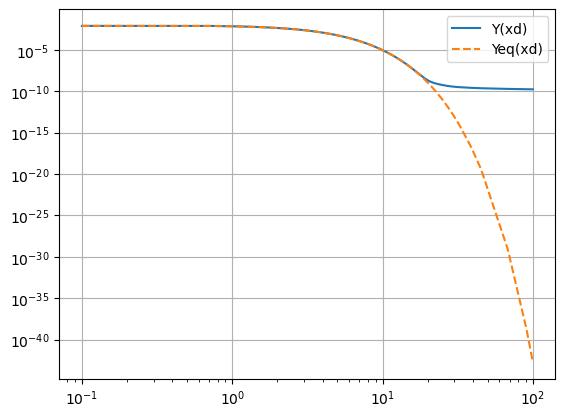

In [21]:
Tvals = mDM/sol.t
for comp in compDict.values():
    if comp.ID == 0: continue
    plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    # plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})', marker='o')
    Yeq = [comp.Yeq(t) for t in Tvals]        
    plt.plot(sol.t,Yeq,label=f'Yeq({comp.label})', linestyle='dashed')

plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-4,10)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

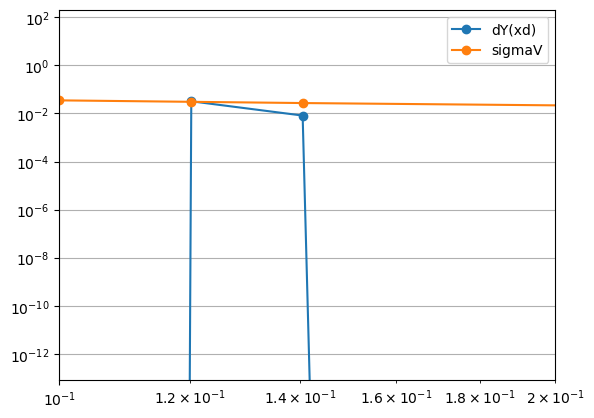

In [16]:
sigmaV = np.array([sum([process.sigmaV(t) for process in model.collisionProcesses]) for t in Tvals])
sigmaV = 1e-2*sigmaV/np.mean(sigmaV)
dY = np.array([dYdx(x,sol.y[:,i],model) for i,x in enumerate(sol.t)]).transpose()
for comp in compDict.values():
    if comp.ID == 0: continue
    # plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    # plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})', marker='o')
    # Yeq = [comp.Yeq(t) for t in Tvals]        
    plt.plot(sol.t,-dY[comp.ID,:],label=f'dY({comp.label})', marker='o')
    plt.plot(sol.t,sigmaV,label=f'sigmaV', marker='o')
plt.vlines(x=0.7,ymin=-0.01,ymax=0.02,colors='gray')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.1,0.2)
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-8,1e8)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

In [17]:
xv =  0.5581856186818792
yv = [2.780e-01,7.80e-03]
computeCollisionTerms(xv,yv,model)

[{},
 {'xdxdx_ddx': 6.743101747743315e-20,
  'xdxdx_uux': 6.743101747743315e-20,
  'xdxdx_ssx': 6.743101747743315e-20,
  'xdxdx_ccx': 6.743101747743315e-20,
  'xdxdx_bbx': 6.743101747743315e-20,
  'xdxdx_ttx': 6.743101747743315e-20}]

In [18]:
setLogLevel('debug')
for i,x in enumerate(sol.t[:3]):
    print(sol.y[1,i])
    print(dYdx(x,sol.y[:,i],model))
    print('\n')

DEBUG in boltzmannEq.dYdx() in 124: x = 1.00e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = 4.540e-33
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.00e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,3.87e-09

DEBUG in boltzmannEq.dYdx() in 124: x = 1.20e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = -5.382e-26
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.20e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,-3.17e-02

DEBUG in boltzmannEq.dYdx() in 124: x = 1.40e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = -1.877e-26
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.40e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,-8.10e-03



0.007802996735312518
[0.00000000e+00 3.86706736e-09]


0.007802996740030538
[ 0.         -0.03170373]


0.007802996736831328
[ 0.         -0.00809974]




In [19]:
comp = compDict[57]
import thermal.equilibriumDensities as eqDensitities
for i,x in enumerate(sol.t[:3]):
    T = mDM/x
    H = eqDensitities.H(T) #hubble rate at temperature T
    dsdx = eqDensitities.dSdx(x, mDM) #variation of entropy with x
    y = sol.y[1,i]
    yeq = comp.Yeq(T)
    sV = sum([process.sigmaV(T) for process in model.collisionProcesses])
    print(f'y = {y:1.3e}, y^2 - yeq^2 = {y**2-yeq**2:1.3e}, sigmaV = {sV:1.3e}')
    print(f'sigmaV*(y^2 -yeq^2) = {(y**2-yeq**2)*sV:1.3e}, -(1/(3*H))*dsdx*(y**2-yeq**2)*sV = {-(1/(3*H))*dsdx*(y**2-yeq**2)*sV:1.3e}')
    print(dYdx(x,sol.y[:,i],model))
    print('\n')

DEBUG in boltzmannEq.dYdx() in 124: x = 1.00e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = 4.540e-33
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.00e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,3.87e-09

DEBUG in boltzmannEq.dYdx() in 124: x = 1.20e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = -5.382e-26
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.20e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,-3.17e-02

DEBUG in boltzmannEq.dYdx() in 124: x = 1.40e-01, Decay = -0.000e+00, Injection = 0.000e+00 and Collision = -1.877e-26
DEBUG in boltzmannEq.dYdx() in 128: Result: x = 1.40e-01, Y = 2.78e-01,7.80e-03, dY = 0.00e+00,-8.10e-03



y = 7.803e-03, y^2 - yeq^2 = 0.000e+00, sigmaV = 8.024e-11
sigmaV*(y^2 -yeq^2) = 0.000e+00, -(1/(3*H))*dsdx*(y**2-yeq**2)*sV = 0.000e+00
[0.00000000e+00 3.86706736e-09]


y = 7.803e-03, y^2 - yeq^2 = 7.363e-14, sigmaV = 6.963e-11
sigmaV*(y^2 -yeq^2) = 5.127e-24, -(1/(3*H))*dsdx*(y**2-yeq**2)*sV = 3.020e+00
[ 0.         -0.03170373]


y = 7.803e-03, y^2 - yeq^2 = 2.370e-14, sigmaV = 6.208e-11
sigmaV*(y^2 -yeq^2) = 1.471e-24, -(1/(3*H))*dsdx*(y**2-yeq**2)*sV = 6.349e-01
[ 0.         -0.00809974]




In [20]:
compDict

{0: SM, 57: xd}